In [1]:
import torch
torch.cuda.empty_cache()
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dev

device(type='cuda')

In [2]:
import lstm_unet

PATH = "lstm_unetCroped.pt"

model = lstm_unet.LSTMUNet(1,2).to(dev)
model.load_state_dict(torch.load(PATH,map_location=dev))

<All keys matched successfully>

In [3]:
import pandas as pd

df = pd.read_json("data/dataset_seq.json")
dataset = pd.read_json("./data/dataset_seq.json")
dataset = dataset.sample(frac=1,random_state=0)[:] # shuffle
#dataset = dataset[:500].copy()
split = int(len(dataset) * 0.9)
df = test_df =  dataset[split:].copy()


In [4]:
from torchvision.transforms import transforms, Lambda
import albumentations as A
from albumentations.pytorch import ToTensorV2
IMAGE_SIZE = 160
CROP_NON_EMPTY_CHANCE = 0.7
transform_test = A.Compose([
                        A.PadIfNeeded(1120,1120,border_mode=0) ,
                        ToTensorV2(),
                    ]   
                     ,additional_targets={ 'image1': 'image','image2': 'image','image3': 'image','image4': 'image'
                                             ,'mask1': 'mask','mask2': 'mask','mask3': 'mask','mask4': 'mask'}  
                    )

torch.Size([5, 1, 1120, 1120])


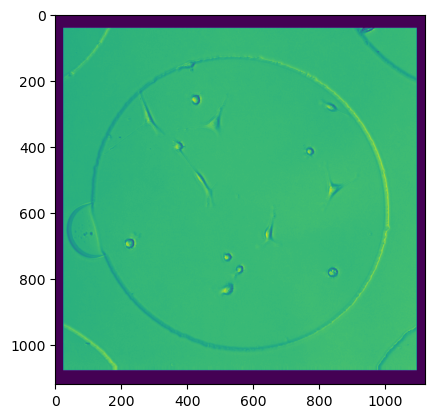

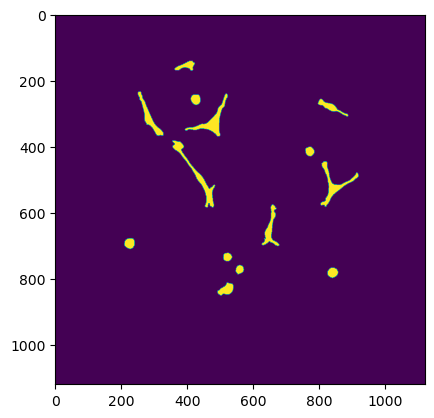

In [5]:
from torch.utils.data import Dataset, DataLoader
from skimage import color, io
import numpy as np
import matplotlib.pyplot as plt
class CellSegmentationDataset(Dataset):
    def __init__(self, data, transform):
        super().__init__()
        self.data = data
        self.transform = transform
        self.to_tensor = transforms.ToTensor()
    def __len__(self):
        return len(self.data)

    def GetWithLabels(self, idx):
        """Same as dataset[idx] but returns labels in anot"""
        imgs = []
        anots =[]
        # load all images in sequence
        for p in zip(self.data["seqence"].iloc[idx], self.data["anot"].iloc[idx]):
            image_filepath = p[0]
            mask_filepath = p[1]
            img =  io.imread(image_filepath).astype(np.int32)
            mask = io.imread(mask_filepath).astype(np.int32)
            imgs.append(img)
            anots.append(mask)

        # transform
        transformed = self.transform(image=imgs[0],image1=imgs[1],image2=imgs[2],image3=imgs[3],image4=imgs[4],
                       mask=anots[0],mask1=anots[1],mask2=anots[2],mask3=anots[3],mask4=anots[4])
       
        image = torch.stack([transformed["image"],transformed["image1"],transformed["image2"],transformed["image3"],transformed["image4"]])
        anot =  torch.stack([transformed["mask"],transformed["mask1"],transformed["mask2"],transformed["mask3"],transformed["mask4"]]) 
        return image, anot.long()
        
    def __getitem__(self, idx):
        imgs = []
        anots =[]
         # load all images in sequence
        for p in zip(self.data["seqence"].iloc[idx], self.data["anot"].iloc[idx]):
            image_filepath = p[0]
            mask_filepath = p[1]
            img =  io.imread(image_filepath).astype(np.uint8)
            mask = io.imread(mask_filepath).astype(np.uint8)
            imgs.append(img)
            anots.append(mask)

        # transform
        transformed = self.transform(image=imgs[0],image1=imgs[1],image2=imgs[2],image3=imgs[3],image4=imgs[4],
                       mask=anots[0],mask1=anots[1],mask2=anots[2],mask3=anots[3],mask4=anots[4])
       
        image = torch.stack([transformed["image"],transformed["image1"],transformed["image2"],transformed["image3"],transformed["image4"]])
        anot =  torch.stack([transformed["mask"],transformed["mask1"],transformed["mask2"],transformed["mask3"],transformed["mask4"]]) > 0
        return image, anot.long()
    
dataset = CellSegmentationDataset(df,transform_test)
idx = 0
out = dataset[idx]
print(out[0].shape)
plt.imshow(out[0][0][0].numpy())
plt.show()
plt.imshow(out[1][0].numpy())
plt.show()



In [6]:
from skimage.morphology import opening,disk, area_opening, closing

from tqdm.notebook import tqdm
from torchmetrics import JaccardIndex
def GetDetection(index,dataset,model):
    test_data,anots = dataset[index]
    # split to slices
    w_slices = test_data[0][0].shape[0] // IMAGE_SIZE
    h_slices = test_data[0][0].shape[1] // IMAGE_SIZE
    results = []
    model.eval()
    with torch.no_grad():
        # for every slice
        for x in range(w_slices):
            for y in range(h_slices):
                img = test_data[:,:,x*160:x*160 + 160,y*160:y*160 + 160]
                res = model(img[:,None].to(dev))
                res = torch.sigmoid(res) 
                res = res.to("cpu").detach().numpy()
                bg, fg = res[-1,0]  # only last element in the sequence 
                results.append(fg>bg)
    res_img =np.array(results)
    # reconstruct the slices
    rec= np.hstack(res_img[:w_slices])
    for y in range(1,h_slices):
        rec = np.vstack([rec,np.hstack(res_img[y*w_slices:y*w_slices+w_slices])])

    # area openning of closing to remove small particles and join disjoint segments
    return area_opening(closing(rec,disk(5)),250)

def Evaluate(dataset, model):
    scores = []
    jaccard = JaccardIndex(num_classes=2,task="binary")
    for i in tqdm(range(0,len(dataset))):
        rec = GetDetection(i,dataset,model)
        _,anots = dataset[i]
        anot = anots[-1]  # only last element in the sequence 
        rec_th = rec  
        # IoU 
        iou_score = jaccard(torch.tensor(rec_th),anot) 
        scores.append(iou_score)
        # if i % 5 == 0:
        #     print(np.mean(scores))
    return np.array(scores)

In [7]:
print(np.mean(Evaluate(dataset,model)))

  0%|          | 0/275 [00:00<?, ?it/s]

0.73682475


# Vizualization

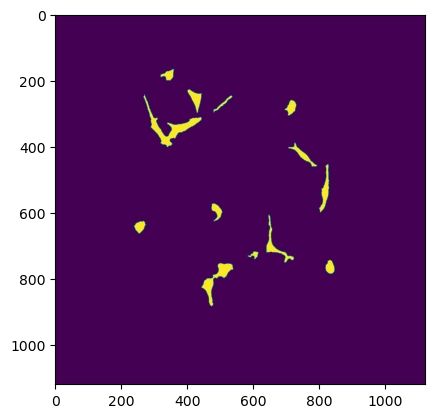

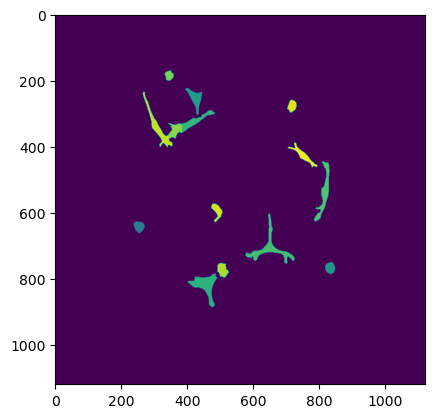

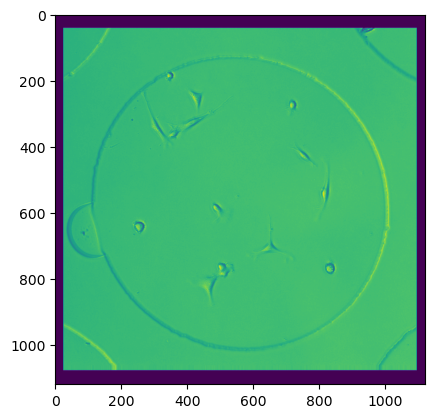

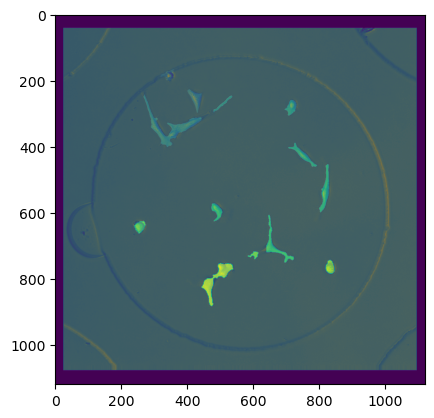

In [20]:
from skimage.morphology import label

index =0#100

rec = GetDetection(index,dataset,model) 
test_data,anots = dataset.GetWithLabels(index)


plt.imshow(rec)
plt.show()



plt.imshow(anots[-1])
plt.show()
plt.imshow(test_data[-1][0])
plt.show()

plt.imshow(test_data[-1][0])
plt.imshow(label(rec),alpha=.5)

# Precision and recall

In [28]:
from skimage.morphology import label

def EvaluatePR(dataset, model,iou_th):
    """Compute tp, fp fn for the dataset"""
    scores = []
    model.eval()
    jaccard = JaccardIndex(num_classes=2,task="binary")
    ctp, cfp, cfn = 0,0,0
    for i in tqdm(range(0,len(dataset))):
        _, anots = dataset.GetWithLabels(i)
        anot = anots[-1].to("cpu").detach().numpy()  # only last element in the sequence 
        rec_th = GetDetection(i,dataset,model) 

        instances = label(rec_th)
        tp, fp, fn = GetStats(instances,anot,iou_th)
        ctp += tp
        cfp += fp
        cfn += fn
    return ctp, cfp, cfn

def GetStats(instances, anot, iou_th):
    """Go through every connected componnet and compute tp, fp, fn"""
    tp = 0
    fp = 0
    fn = 0
    
    notused = np.ones(np.max(instances))
    for l in range(1,np.max(anot)+1):
        best_score = 0.0
        best_label = 0
        if np.max(anot == l) == False: # some annotation labels are just empty
            continue
        for dl in range(1,np.max(instances)+1):
            a = instances == dl # get component from the detection
            b = anot == l # get component from 
            # IoU
            intersection = np.logical_and(a, b)
            union = np.logical_or(a, b)
            iou_score = np.sum(intersection) / np.sum(union)
            if iou_score > best_score:
                best_score =iou_score
                best_label = dl
        if best_score > iou_th:
            tp +=1
            notused[best_label-1] = 0 
        else:
            fn += 1
    fp = np.sum(notused) # componnets not in the annotation are false negatives
    return tp, fp, fn

tprec = []
trecall = []
for ioth in [0.25,0.5,0.75]:
    tp, fp, fn = EvaluatePR(dataset,model,ioth)
    print(tp,fp,fn)
    prec = tp / (tp+fp)
    recall = tp / (tp + fn)
    print(prec, recall, ioth )
    tprec.append(prec)
    trecall.append(recall)



  0%|          | 0/275 [00:00<?, ?it/s]

1183 73.0 87
0.9418789808917197 0.931496062992126 0.25


  0%|          | 0/275 [00:00<?, ?it/s]

932 219.0 338
0.8097306689834927 0.7338582677165354 0.5


  0%|          | 0/275 [00:00<?, ?it/s]

609 542.0 661
0.529105125977411 0.4795275590551181 0.75


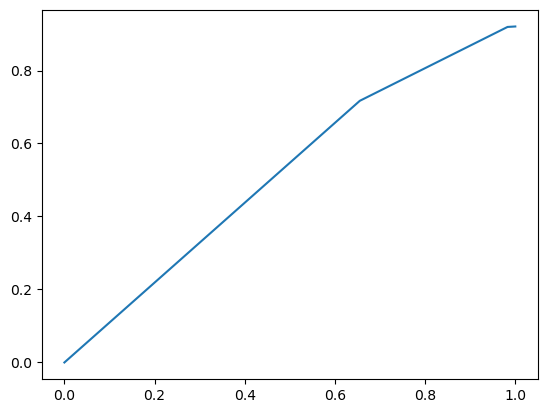

In [ ]:
xs, ys = zip(*sorted(zip(trecall, tprec)))


plt.plot(xs,ys)